# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></div><div class="lev1 toc-item"><a href="#Word-Segmentation" data-toc-modified-id="Word-Segmentation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Word Segmentation</a></div><div class="lev1 toc-item"><a href="#Tokenize-Text" data-toc-modified-id="Tokenize-Text-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Tokenize Text</a></div><div class="lev1 toc-item"><a href="#Word-Embedding" data-toc-modified-id="Word-Embedding-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Word Embedding</a></div><div class="lev2 toc-item"><a href="#Read-Pretrained-Model" data-toc-modified-id="Read-Pretrained-Model-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Read Pretrained Model</a></div><div class="lev2 toc-item"><a href="#Use-Word2vec-to-Initialize-Embedding-Matrix" data-toc-modified-id="Use-Word2vec-to-Initialize-Embedding-Matrix-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Use Word2vec to Initialize Embedding Matrix</a></div><div class="lev1 toc-item"><a href="#Build-Dateset" data-toc-modified-id="Build-Dateset-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Build Dateset</a></div><div class="lev1 toc-item"><a href="#Build-Model" data-toc-modified-id="Build-Model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Build Model</a></div><div class="lev2 toc-item"><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-61"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Import Libraries</a></div><div class="lev2 toc-item"><a href="#Model-Visualization" data-toc-modified-id="Model-Visualization-62"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Model Visualization</a></div><div class="lev2 toc-item"><a href="#Train" data-toc-modified-id="Train-63"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Train</a></div><div class="lev2 toc-item"><a href="#Plot-Results" data-toc-modified-id="Plot-Results-64"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Plot Results</a></div><div class="lev1 toc-item"><a href="#Evaluate" data-toc-modified-id="Evaluate-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Evaluate</a></div>

# Load Data

In [1]:
import json
import os

In [2]:
def load_data(path, name):
    """
    Load date from file
    """
    data = []
    input_file = os.path.join(path)
    with open(input_file) as f:
        lines = f.readlines()
    for line in lines:
        item = json.loads(line)
        data.append(item[name])
    return data

In [3]:
sentence = load_data('done_data.json', 'sentence')
label = load_data('done_data.json', 'label')

# Word Segmentation

In [4]:
import jieba
import re
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
not_cuts = re.compile(u'([\da-zA-Z\.]+)')
re_replace = re.compile(u'([^\u4e00-\u9fa50-9a-zA-Z\%《》\(\)（）“”·\.])|（(.*?)）|\((.*?)\)')

In [6]:
filename = "stopwords.txt"
stopWords = [w for w in open(filename).read().split()]

In [7]:
def newcut(s):
    """
    Word Segmentation
    """
    result = []
    j = 0
    s = re_replace.sub('', s)
    
    for i in not_cuts.finditer(s):
        result.extend(jieba.lcut(s[j:i.start()], HMM=False))
        result.append(s[i.start():i.end()])
        j = i.end()
    result.extend(jieba.lcut(s[j:], HMM=False))
    return result

def del_stop(ws):
    """
    Delete stopwords
    """
    return [i for i in ws if i not in stopWords]

In [8]:
sentWords = [del_stop(newcut(s)) for s in sentence]

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/kz/hqjl_dfx3g3_2vxylxlj1s940000gn/T/jieba.cache
Loading model cost 0.968 seconds.
Prefix dict has been built succesfully.


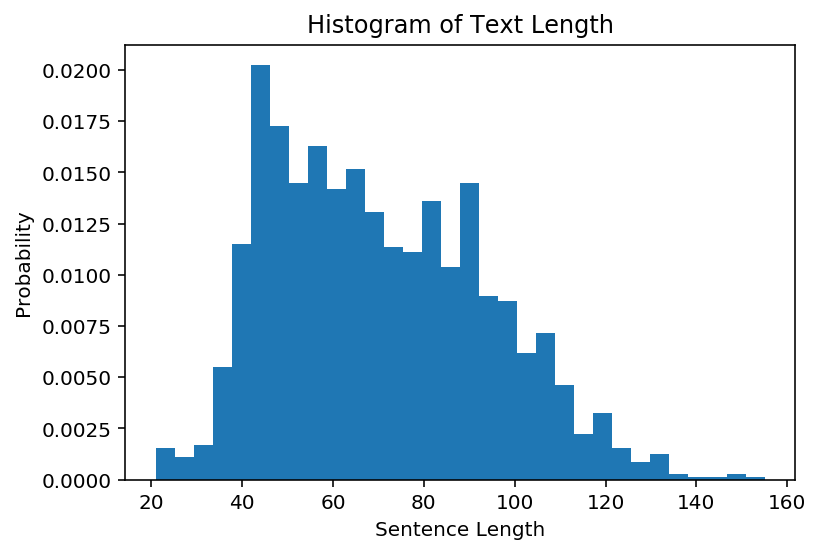

In [9]:
plt.hist([len(i) for i in sentWords], bins=32, normed=True);
plt.xlabel('Sentence Length')
plt.ylabel('Probability')
plt.title('Histogram of Text Length')  

# Tokenize Text

In [10]:
from keras.preprocessing.text import Tokenizer
import numpy as np

Using TensorFlow backend.


In [11]:
tokWords = sentWords.copy()
tokTexts = [' '.join(i) for i in tokWords]
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(tokTexts)
word2index = tokenizer.word_index
index2word = {i: w for w, i in word2index.items()}
sentLens = np.array([len(i) for i in sentWords])
print('Number of sentences: \t{:d}'.format(len(sentLens)))
print('Distribution of sentence lengths (number of words):')
print('Min: {:d}   Max: {:d}   Mean: {:.3f}   Med: {:.3f}'.format(np.min(sentLens), np.max(sentLens), np.mean(sentLens), np.median(sentLens)))
print('Found %s unique tokens.' % len(word2index))

Number of sentences: 	1700
Distribution of sentence lengths (number of words):
Min: 21   Max: 155   Mean: 70.308   Med: 68.000
Found 14681 unique tokens.


In [12]:
MAX_LEN = 150 # Approximately twice the median length of sentences

# Word Embedding

In [13]:
VOCAB_SIZE = len(index2word)+1
EMBEDDING_SIZE = 256
SEED = 42

## Read Pretrained Model

In [14]:
import gensim

In [15]:
word2vec = gensim.models.Word2Vec.load('/Users/lizhn7/Downloads/DATA/word2vec/word2vec_wx')
word2vec.init_sims(replace=True)
w2v_embedding_weights = word2vec.wv.syn0
w2v_embedding_weights.std()

0.062499415

## Use Word2vec to Initialize Embedding Matrix 

In [16]:
# Generate random embedding with same scale as glove
np.random.seed(SEED)
shape = (VOCAB_SIZE, EMBEDDING_SIZE)
scale = w2v_embedding_weights.std() * np.sqrt(12) / 2 
embedding = np.random.uniform(low=-scale, high=scale, size=shape)

In [17]:
count = 0
w2v_dict = word2vec.wv.index2word
for i in range(1, VOCAB_SIZE):
    w = index2word[i]
    if w in w2v_dict:
        g = word2vec[w]
        embedding[i, :] = g
        count += 1
print('{num_tokens}-{per:.3f}% tokens in vocab found in word2vec and copied to embedding.'.format(num_tokens=count, per=count/float(VOCAB_SIZE)*100))

11926-81.229% tokens in vocab found in word2vec and copied to embedding.


# Build Dateset

In [18]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [19]:
def convert_seq(ws, label):
    """
    Pad words sequene to MAX_LEN and encode label to one-hot encoding
    """
    sentText = [' '.join(i) for i in ws]
    sentSeq = tokenizer.texts_to_sequences(sentText)
    sentData = pad_sequences(sentSeq, maxlen=MAX_LEN, padding='post', truncating='post')
    labelData = np.array([[i] for i in label])
    return sentData, labelData 

In [20]:
x, y = convert_seq(sentWords, label)

In [21]:
xTrain, xVal, yTrain, yVal = train_test_split(x, y, test_size=0.3, random_state=SEED)

# Build Model

In [33]:
#MAX_LEN = 
#VOCAB_SIZE = 
#EMBEDDING_SIZE = 
#RNN_SIZE = 
CNN_SIZE = 128
WINDOW_SIZE = 3
DROPOUT_RATE = 0.5
#RNN_DROPOUT_RATE = 
NUM_EPOCHS = 32
BATCH_SIZE = 32

## Import Libraries

In [34]:
from keras.layers import Input, Embedding, Dropout, Bidirectional, LSTM, Reshape, concatenate, Conv1D, BatchNormalization, GlobalMaxPooling1D, Dense
from keras.models import Model
import keras.backend as K
from keras.callbacks import*
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [35]:
K.clear_session()
seq = Input(shape=(MAX_LEN,), name='INPUT') 
emb_seq = Embedding(VOCAB_SIZE, EMBEDDING_SIZE, weights=[embedding], mask_zero=False, input_length=MAX_LEN, trainable=False, name='EMBEDDING')(seq)
#emb_seq = Dropout(DROPOUT_RATE, name='DROPOUT_1')(emb_seq)
#blstm = Bidirectional(LSTM(RNN_SIZE, return_sequences=True, implementation=0, dropout=RNN_DROPOUT_RATE, recurrent_dropout=RNN_DROPOUT_RATE), merge_mode='concat', name='BiLSTM_1')(emb_seq)
#blstm = Dropout(DROPOUT_RATE, name='DROPOUT_2')(blstm)
#blstm = Bidirectional(LSTM(RNN_SIZE, return_sequences=True, implementation=0, dropout=RNN_DROPOUT_RATE, recurrent_dropout=RNN_DROPOUT_RATE), merge_mode='concat', name='BiLSTM_2')(blstm)
#blstm = Dropout(DROPOUT_RATE, name='DROPOUT_3')(blstm)
conv = Conv1D(CNN_SIZE, WINDOW_SIZE, padding='same', activation='elu', name='CONV')(emb_seq)
pool = GlobalMaxPooling1D(name='MAXPOOLING')(conv)
pool = Dropout(DROPOUT_RATE, name='DROPOUT_2')(pool)
output = Dense(1, activation='sigmoid', name='OUTPUT')(pool)
model = Model(inputs=seq, outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam')

## Model Visualization

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           (None, 150)               0         
_________________________________________________________________
EMBEDDING (Embedding)        (None, 150, 256)          3758592   
_________________________________________________________________
CONV (Conv1D)                (None, 150, 128)          98432     
_________________________________________________________________
MAXPOOLING (GlobalMaxPooling (None, 128)               0         
_________________________________________________________________
DROPOUT_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
OUTPUT (Dense)               (None, 1)                 129       
Total params: 3,857,153
Trainable params: 98,561
Non-trainable params: 3,758,592
_____________________________________________________________

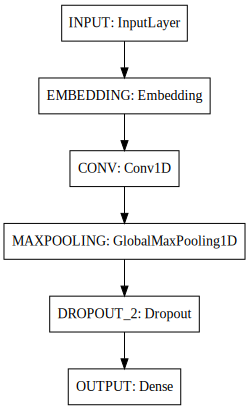

In [36]:
model.summary()
SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Train

In [37]:
filepath = '/Users/lizhn7/Downloads/DATA/chinese_news/mini/cp_logs/weights.{epoch:03d}-{val_loss:.6f}.hdf5'
log_string = '/Users/lizhn7/Downloads/DATA/chinese_news/mini/tb_logs/mini'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
tensorboard = TensorBoard(log_dir=log_string) 

In [38]:
history = model.fit(xTrain,
                    yTrain,
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS, 
                    verbose=1,
                    callbacks=[checkpoint],
                    validation_data=(xVal, yVal), 
                    shuffle=True)

Train on 1190 samples, validate on 510 samples
Epoch 1/32
1190/1190 [==============================] - 4s - loss: 0.6848 - val_loss: 0.6489
Epoch 2/32
1190/1190 [==============================] - 4s - loss: 0.6272 - val_loss: 0.5813
Epoch 3/32
1190/1190 [==============================] - 4s - loss: 0.5288 - val_loss: 0.4981
Epoch 4/32
1190/1190 [==============================] - 3s - loss: 0.4475 - val_loss: 0.4321
Epoch 5/32
1190/1190 [==============================] - 4s - loss: 0.3685 - val_loss: 0.3750
Epoch 6/32
1190/1190 [==============================] - 3s - loss: 0.3184 - val_loss: 0.3462
Epoch 7/32
1190/1190 [==============================] - 3s - loss: 0.2844 - val_loss: 0.3226
Epoch 8/32
1190/1190 [==============================] - 3s - loss: 0.2604 - val_loss: 0.3086
Epoch 9/32
1190/1190 [==============================] - 3s - loss: 0.2289 - val_loss: 0.2966
Epoch 10/32
1190/1190 [==============================] - 3s - loss: 0.2071 - val_loss: 0.2870
Epoch 11/32
1190/1190 

1190/1190 [==============================] - 3s - loss: 0.0300 - val_loss: 0.2604
Epoch 31/32
1190/1190 [==============================] - 3s - loss: 0.0254 - val_loss: 0.2634
Epoch 32/32
1190/1190 [==============================] - 3s - loss: 0.0245 - val_loss: 0.2675


## Plot Results

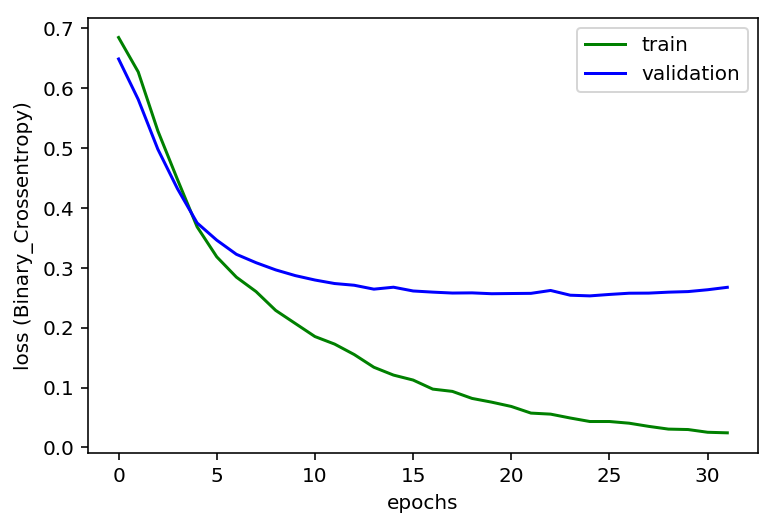

In [39]:
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.ylabel("loss (Binary_Crossentropy)")
plt.xlabel("epochs")
plt.legend(loc="best")
plt.show()

# Evaluate

In [40]:
threshold = [i/10 for i in range(1, 9, 1)]

In [41]:
def calculate(pred, actu, THRESHOLD=0.5, t=1, f=0):
    """
    Calculate Precision Recall F1-score
    """
    pred = [1 if i >= THRESHOLD else 0 for i in pred]
    actu = sum([list(i) for i in actu], [])
    CTP = sum([1 for i in range(len(pred)) if pred[i] == t and actu[i] == t])
    CFN = sum([1 for i in range(len(pred)) if pred[i] == f and actu[i] == t])
    CFP = sum([1 for i in range(len(pred)) if pred[i] == t and actu[i] == f])
    CTN = sum([1 for i in range(len(pred)) if pred[i] == f and actu[i] == f])
    NCTP = CTN
    NCFN = CFP
    NCFP = CFN
    NCTN = CTP
    CP = CTP/(CTP+CFP)
    CR = CTP/(CTP+CFN)
    CF1 = 2*CP*CR/(CP+CR)
    NCP = NCTP/(NCTP+NCFP)
    NCR = NCTP/(NCTP+NCFN)
    NCF1 = 2*NCP*NCR/(NCP+NCR)
    ACC = (CTP+CTN)/(CTP+CFP+CFN+CTN)
    print('Threshold: \t%.3f' % (THRESHOLD))
    print('Causal: \tPreciion %.3f \tRecall %.3f \tF1-score %.3f \tAccuracy: %.3f' % (CP, CR, CF1, ACC))
    #print('Non-Causal: \tPreciion %.3f \tRecall %.3f \tF1-score %.3f' % (NCP, NCR, NCF1))
    print('Accuracy: \t%.3f' % (ACC))

In [44]:
def prt(pred, actu, THRESHOLD):
    """
    Print result
    """
    causalDict = {1: 'Causal', 0: 'Non-Causal'}
    pred = [1 if i >= THRESHOLD else 0 for i in pred]
    actu = sum([list(i) for i in actu], [])
    for i in range(len(pred)):
        if pred[i] != actu[i]:
            print('Predict Result: \t%s' % causalDict[pred[i]])
            print('Actual Result: \t\t%s' % causalDict[actu[i]])
            print('Sentence: %s' % '/'.join([index2word[j] for j in xVal[i] if j != 0]))
            print('————————————')

In [42]:
filename = '/Users/lizhn7/Downloads/DATA/chinese_news/mini/cp_logs/weights.024-0.253188.hdf5'
model.load_weights(filename)
result = model.predict(xVal, batch_size=BATCH_SIZE, verbose=1)

#model.summary()

for THRESHOLD in threshold:
    calculate(result, yVal, THRESHOLD=THRESHOLD)
    print('————————————————————————')
    
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

480/510 [===========================>..] - ETA: 0sThreshold: 	0.100
Causal: 	Preciion 0.723 	Recall 0.966 	F1-score 0.827 	Accuracy: 0.816
Accuracy: 	0.816
————————————————————————
Threshold: 	0.200
Causal: 	Preciion 0.797 	Recall 0.948 	F1-score 0.866 	Accuracy: 0.867
Accuracy: 	0.867
————————————————————————
Threshold: 	0.300
Causal: 	Preciion 0.857 	Recall 0.905 	F1-score 0.881 	Accuracy: 0.888
Accuracy: 	0.888
————————————————————————
Threshold: 	0.400
Causal: 	Preciion 0.895 	Recall 0.884 	F1-score 0.889 	Accuracy: 0.900
Accuracy: 	0.900
————————————————————————
Threshold: 	0.500
Causal: 	Preciion 0.913 	Recall 0.858 	F1-score 0.884 	Accuracy: 0.898
Accuracy: 	0.898
————————————————————————
Threshold: 	0.600
Causal: 	Preciion 0.927 	Recall 0.819 	F1-score 0.870 	Accuracy: 0.888
Accuracy: 	0.888
————————————————————————
Threshold: 	0.700
Causal: 	Preciion 0.940 	Recall 0.806 	F1-score 0.868 	Accuracy: 0.888
Accuracy: 	0.888
————————————————————————
Threshold: 	0.800
Causal: 	Precii

In [45]:
prt(result, yVal, 0.4)

Predict Result: 	Causal
Actual Result: 		Non-Causal
Sentence: 基础/层/公司/韵/文化/主办/券商/华/创/证券/周三/晚间/发布/风险/提示/称/韵/文化/未能/按时/完成/2016/年/年度报告/持续/经营/能力/不确定性/华/创/证券/表示/截至/公告/发布/日/韵/文化/仍/尚未/完成/2016/年/年度报告/编制/披露/工作/韵/文化/董事会/已/决定/申请/公司股票/全国/中小企业/股份/转让/系统/终止/挂牌/韵/文化/股票/终止/挂牌/风险/截至/公告/发布/日/韵/文化/尚未/重新/获取/太极/剧场/经营/管理权/主营业务/尚未/正式/亦/未/获得/持续性/收入/近日/韵/文化/董/监/高/发生/变化/韵/文化/持续/经营/能力/不确定性/风险
————————————
Predict Result: 	Non-Causal
Actual Result: 		Causal
Sentence: 8/月/9/日/美国/纽/交/上市/汽车/家/公布/财/报/显示/2017/年/第二季度/公司/净/营/收/同比/增长/13.3/%/净利润/同比/增长/49.7/%/双双/超出/市场/预期/公司/表示/上半年/国内汽车/产销/增速/同比/下滑/背景/下/公司业绩/快速增长/得益于/公司/ar/网上/车展/经销商/服务平台/二手车/家/服务/云/平台/创新/模式/上/拓展/公司/正/持续/发/力/数据/技术/领域/加速/平台/化/转型
————————————
Predict Result: 	Non-Causal
Actual Result: 		Causal
Sentence: 加拿大/石油/天然气/公司/加拿大/自然资源/canadiannaturalresources/周四/发布/财/报/显示/公司/第二季度/实现/净利/7.967/亿美元/上一年/同期/亏损/合每股/净/收益/69/美分/非/经常性/收益/幷/购/相关/收益/调整/后/每股/收益/为/22/美分/好/华尔街/预期/18/美/分公司/期/收入/27.6/亿美元/好/华尔街/预期/26.1/亿美元/迄今/股/股价/下跌/约/4/%/过去/12/月/上涨/近/4/%
————————————
Predict Result: 	C